In [126]:
!pip install pandas
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: C:\Users\jpedr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Objetivo: importar bibliotecas essenciais para análise, visualização e normalização dos dados.


In [128]:
column_names = ['Sex', 'Length', 'Diameter', 'Height', 
                'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 
                'ShellWeight', 'Rings']

df = pd.read_csv("abalone.data", header=None, names=column_names)

# Carregamos o arquivo `abalone.data` com nomes de colunas definidos manualmente

In [129]:
df.head()


,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   object 
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [131]:
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


A variância nos valores sugere que deveremos normalizar o df para algoritmos de clusterização sensíveis.

In [132]:
df.isnull().sum()

# Confirmamos que não há valores nulos no dataset (como esperado)


Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64

In [133]:
df_processed = df.copy() # Criamos uma cópia que servirá para as transformações que serão feitas

# A ideia é manter o DataFrame original intacto para referência e comparações futuras

Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


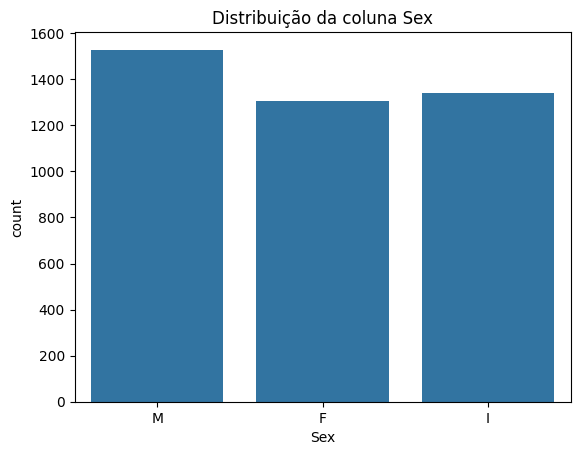

In [134]:
print(df_processed['Sex'].value_counts())

sns.countplot(x='Sex', data=df_processed)
plt.title('Distribuição da coluna Sex')
plt.show()

# Útil para visualizar distribuição das categorias M, F e I (infant)


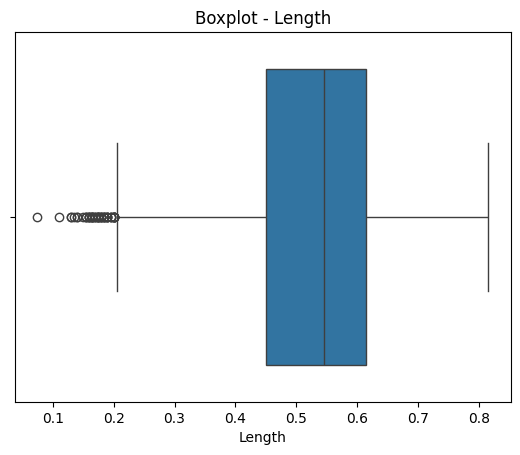

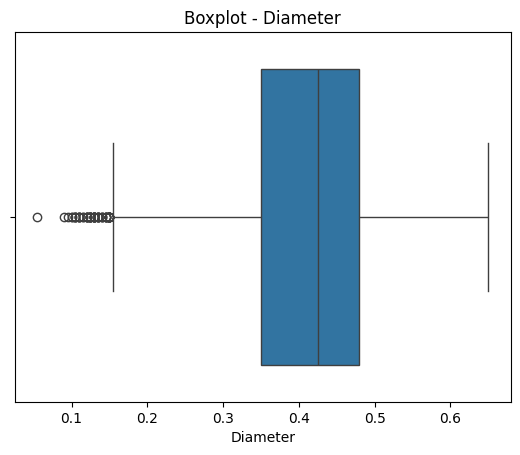

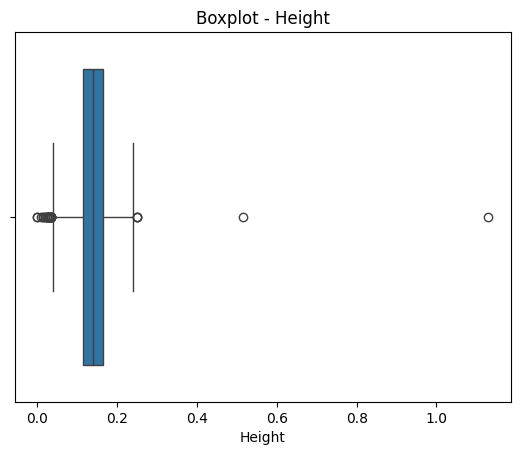

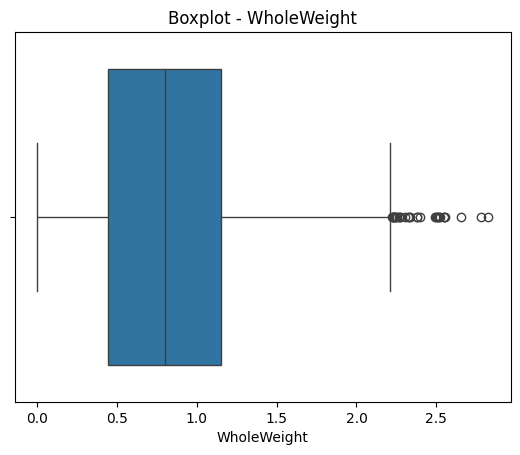

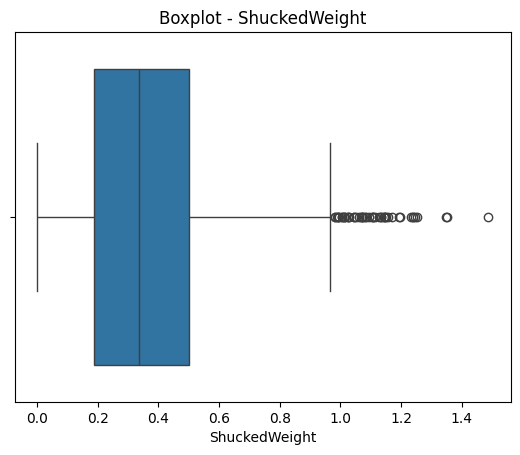

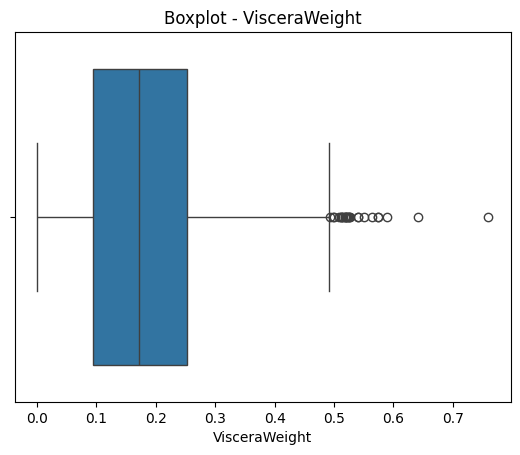

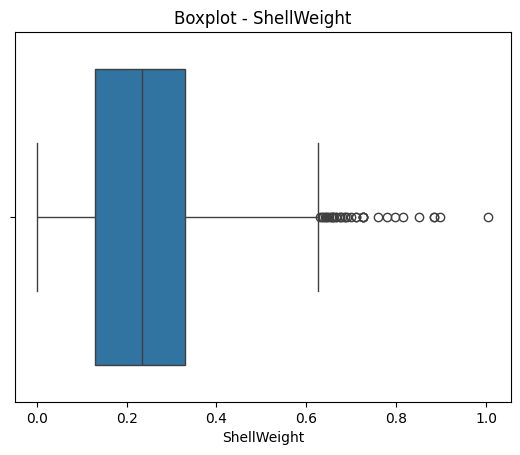

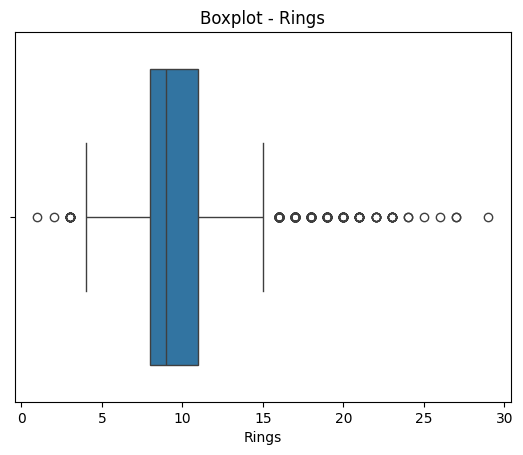

In [135]:
for col in df_processed.columns[1:]: # Excluindo a coluna 'Sex'
    sns.boxplot(x=df_processed[col])
    plt.title(f'Boxplot - {col}')
    plt.show()


In [136]:
# A coluna Sex é categórica e precisa ser convertida em variáveis dummy para análise quantitativa.
df_sex_encoded = pd.get_dummies(df_processed['Sex'], prefix='Sex', dtype=int)

# Retiramos a coluna 'Sex' do DataFrame original e adicionamos as colunas dummy criadas.
df_processed = pd.concat([df_processed, df_sex_encoded], axis=1)
df_processed = df_processed.drop('Sex', axis=1)

df_processed.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [137]:
# Quantidade de abalones com altura zero
num_abalone_zero_height = df_processed[df_processed['Height'] == 0].shape[0]
total_abalone = df_processed.shape[0]
percentage_zero_height = (num_abalone_zero_height / total_abalone) * 100

print(f"Número de abalones com Height = 0: {num_abalone_zero_height}")
print(f"Porcentagem de abalones com Height = 0: {percentage_zero_height:.2f}%")

Número de abalones com Height = 0: 2
Porcentagem de abalones com Height = 0: 0.05%


In [138]:
# Remover linhas onde 'Height' é igual a 0
df_processed = df_processed[df_processed['Height'] != 0].copy()
df_processed.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_F,Sex_I,Sex_M
count,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090,0.313054,0.320958,0.365988
std,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227,0.463792,0.466901,0.481764
min,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000,0.000000,0.000000,0.000000
25%,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000,0.000000,0.000000,0.000000
50%,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000,0.000000,0.000000,0.000000
75%,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000,1.000000,1.000000,1.000000
max,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000,1.000000,1.000000,1.000000


In [139]:
features_to_standardize = df_processed.iloc[:, :-3].columns.tolist()

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

df_processed = remove_outliers_iqr(df_processed, features_to_standardize)

# Reduzimos ruídos extremos que poderiam distorcer a clusterização


In [140]:
scaler = StandardScaler()


df_processed[features_to_standardize] = scaler.fit_transform(df_processed[features_to_standardize])

print("\nEstatísticas descritivas do DataFrame padronizado:")
print(df_processed.describe())

# Padronizamos os dados para média 0 e desvio padrão 1



Estatísticas descritivas do DataFrame padronizado:
             Length      Diameter        Height   WholeWeight  ShuckedWeight  \
count  3.773000e+03  3.773000e+03  3.773000e+03  3.773000e+03   3.773000e+03   
mean  -1.393590e-16 -4.143106e-17  6.402983e-17 -1.450087e-16  -2.636522e-17   
std    1.000133e+00  1.000133e+00  1.000133e+00  1.000133e+00   1.000133e+00   
min   -2.836136e+00 -2.710754e+00 -2.760772e+00 -1.689706e+00  -1.625262e+00   
25%   -6.348365e-01 -6.479348e-01 -7.722874e-01 -8.079678e-01  -8.167406e-01   
50%    1.288795e-01  1.663360e-01  7.992036e-02 -5.396840e-02  -9.942463e-02   
75%    8.027466e-01  7.634679e-01  7.900935e-01  7.362049e-01   7.140265e-01   
max    2.150481e+00  2.120586e+00  2.920613e+00  3.024203e+00   3.023735e+00   

       VisceraWeight   ShellWeight         Rings        Sex_F        Sex_I  \
count   3.773000e+03  3.773000e+03  3.773000e+03  3773.000000  3773.000000   
mean    1.224100e-16 -2.824845e-17 -6.779629e-17     0.305592     0.334

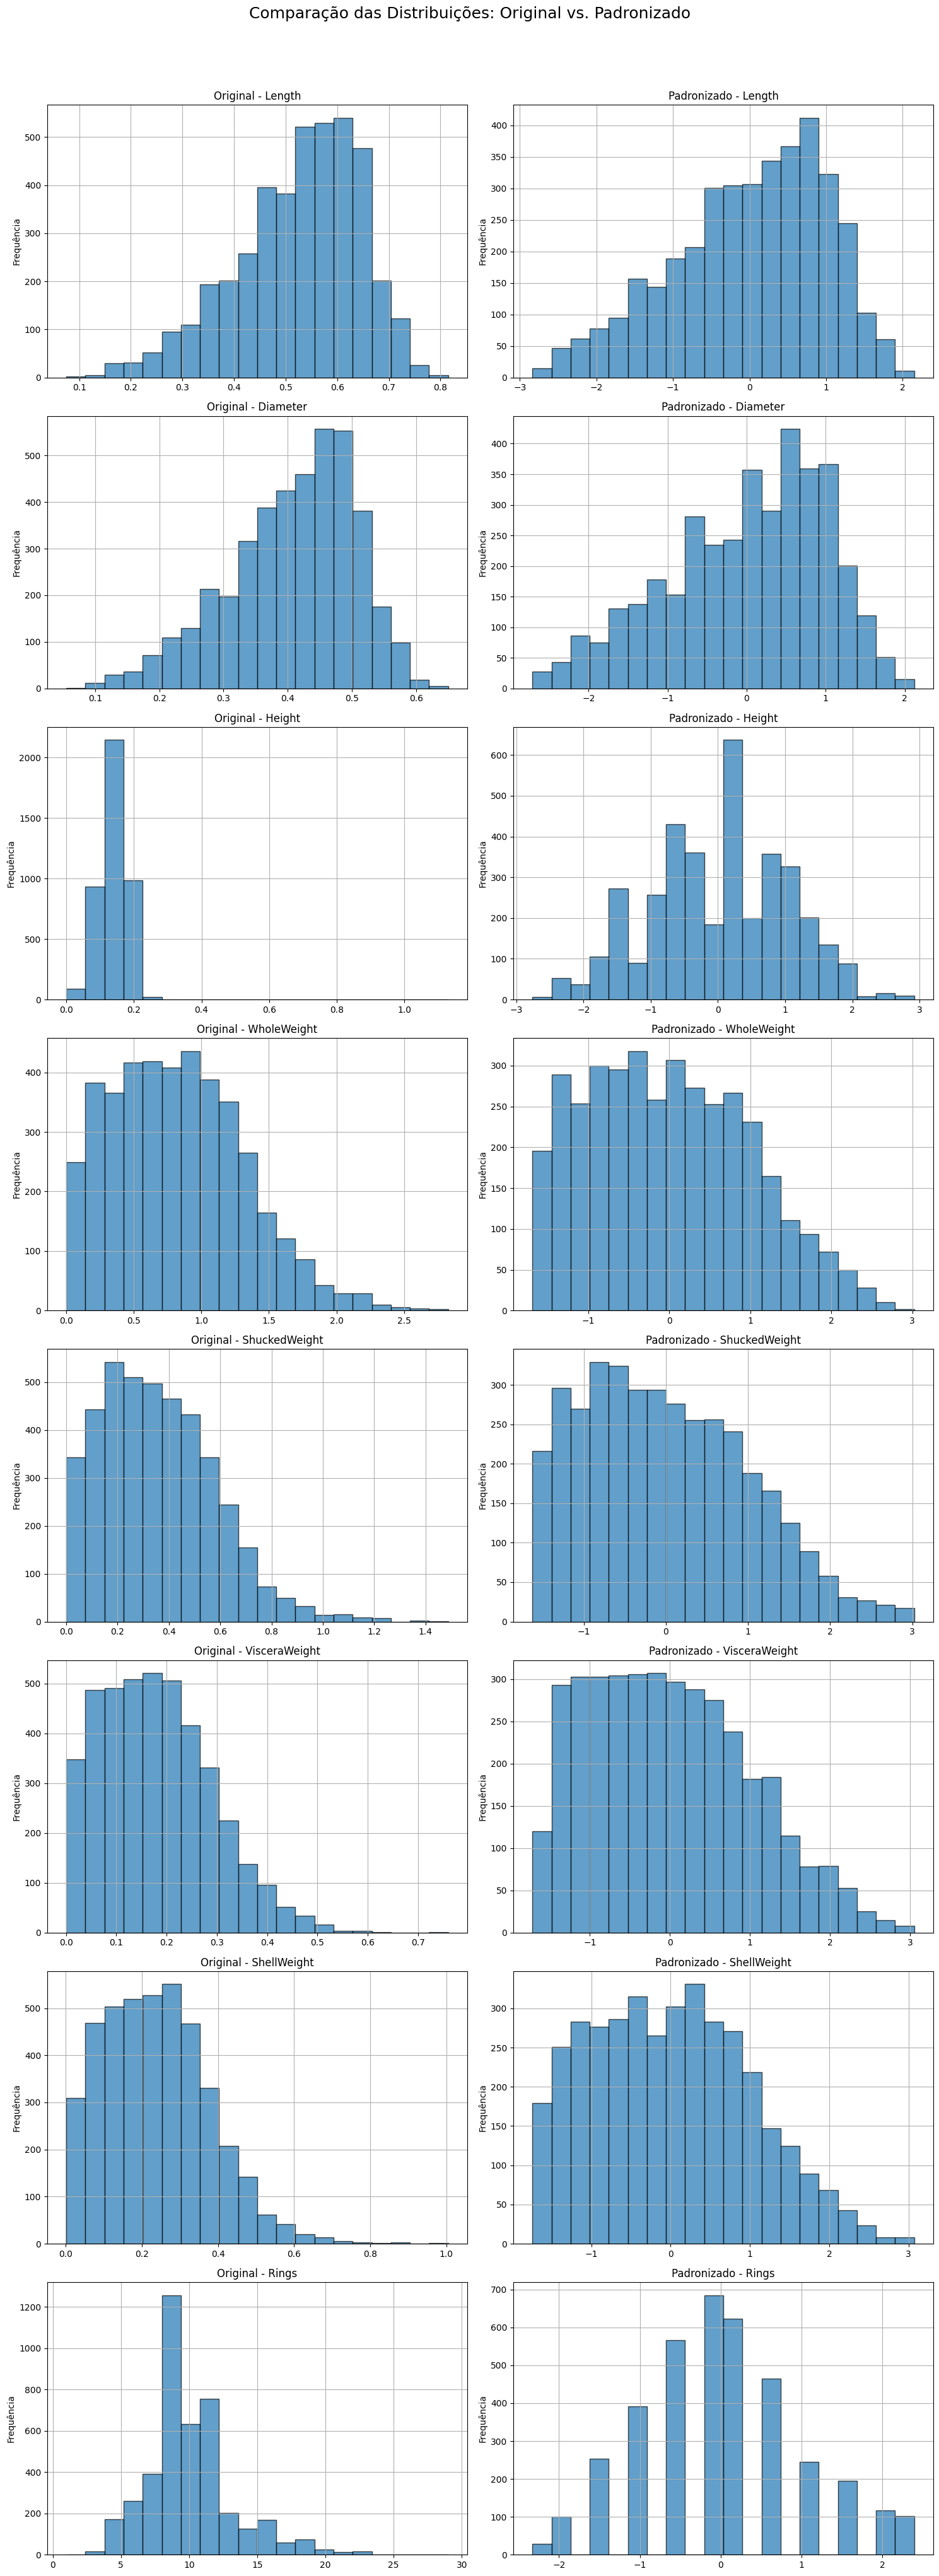

In [145]:
fig, axes = plt.subplots(nrows=len(features_to_standardize), ncols=2, figsize=(15, 5 * len(features_to_standardize)))

fig.suptitle("Comparação das Distribuições: Original vs. Padronizado", fontsize=18, y=1.02)

for i, feature in enumerate(features_to_standardize):
    # Histograma do df original
    axes[i, 0].hist(df[feature], bins=20, edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f"Original - {feature}")
    axes[i, 0].grid(True)
    axes[i, 0].set_ylabel("Frequência")

    # Histograma do df padronizado
    axes[i, 1].hist(df_processed[feature], bins=20, edgecolor='black', alpha=0.7)
    axes[i, 1].set_title(f"Padronizado - {feature}")
    axes[i, 1].grid(True)
    axes[i, 1].set_ylabel("Frequência")

plt.tight_layout(rect=[0, 0, 1, 1]) # layout ajustado para evitar sobreposição de títulos
plt.show()


C:\Users\jpedr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


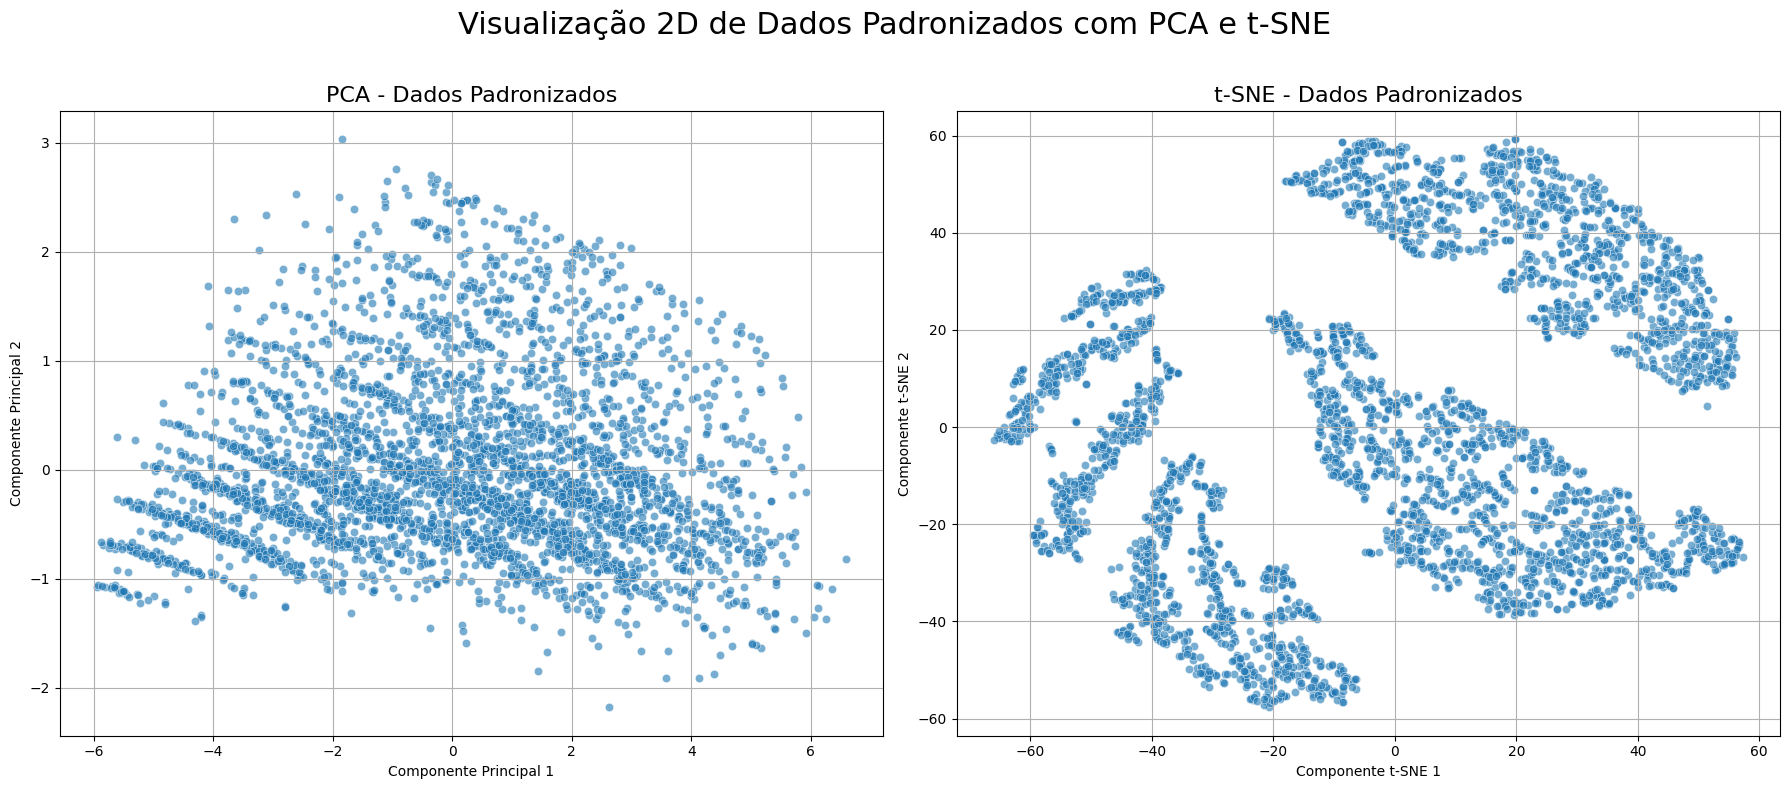

In [157]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_scaled = PCA(n_components=2, random_state=42)
X_pca_processed = pca_scaled.fit_transform(df_processed)

tsne_scaled = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne_processed = tsne_scaled.fit_transform(df_processed)

# Gráfico de dispersão para PCA e t-SNE
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
fig.suptitle("Visualização 2D de Dados Padronizados com PCA e t-SNE", fontsize=22)

# Plot PCA
sns.scatterplot(x=X_pca_processed[:, 0], y=X_pca_processed[:, 1], ax=axes[0], alpha=0.6)
axes[0].set_title('PCA - Dados Padronizados', fontsize=16)
axes[0].set_xlabel('Componente Principal 1')
axes[0].set_ylabel('Componente Principal 2')
axes[0].grid(True)

# Plot t-SNE
sns.scatterplot(x=X_tsne_processed[:, 0], y=X_tsne_processed[:, 1], ax=axes[1], alpha=0.6)
axes[1].set_title('t-SNE - Dados Padronizados', fontsize=16)
axes[1].set_xlabel('Componente t-SNE 1')
axes[1].set_ylabel('Componente t-SNE 2')
axes[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

K-MEANS

In [142]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA


Método do Cotovelo

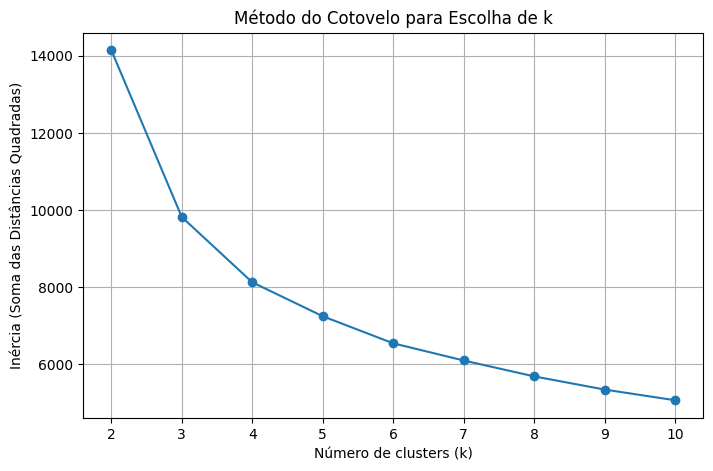

In [158]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das Distâncias Quadradas)')
plt.title('Método do Cotovelo para Escolha de k')
plt.grid(True)
plt.show()

# Justificativa:
# A "inércia" mede quão compactos estão os clusters. O "cotovelo" indica onde a melhoria se estabiliza.


Análise de Silhueta

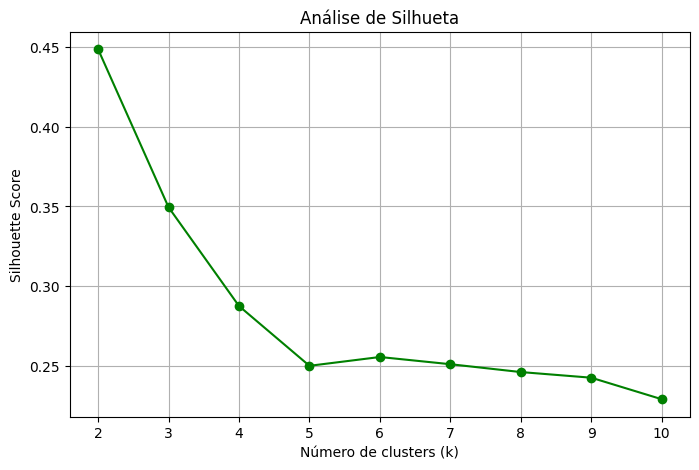

In [159]:
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_processed)
    score = silhouette_score(df_processed, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o', color='green')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Análise de Silhueta')
plt.grid(True)
plt.show()

# Justificativa:
# O Silhouette Score varia de -1 a 1 e mede a coesão e separação dos clusters.
# Quanto mais próximo de 1, melhor os clusters estão definidos.


In [177]:
def PlotKmeans(best_k):
    kmeans = KMeans(n_clusters=best_k, random_state=42)
    labels = kmeans.fit_predict(df_processed)

    df_processed['Cluster_KMeans'] = labels

    sil_score = silhouette_score(df_processed.drop('Cluster_KMeans', axis=1), labels)
    db_score = davies_bouldin_score(df_processed.drop('Cluster_KMeans', axis=1), labels)
    ch_score = calinski_harabasz_score(df_processed.drop('Cluster_KMeans', axis=1), labels)

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Davies-Bouldin Score: {db_score:.3f}")
    print(f"Calinski-Harabasz Score: {ch_score:.3f}")

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_processed.drop('Cluster_KMeans', axis=1))

    df_processed['PCA1'] = pca_result[:, 0]
    df_processed['PCA2'] = pca_result[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='viridis', data=df_processed)
    plt.title(f'Clusters KMeans com k={best_k} (PCA 2D)')
    plt.legend(title='Cluster')
    plt.show()


Silhouette Score: 0.506
Davies-Bouldin Score: 0.692
Calinski-Harabasz Score: 6350.997


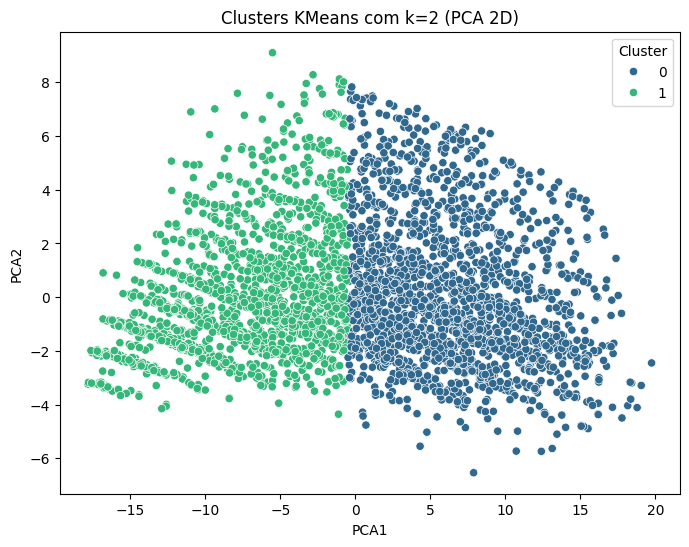

Silhouette Score: 0.372
Davies-Bouldin Score: 0.876
Calinski-Harabasz Score: 6008.999


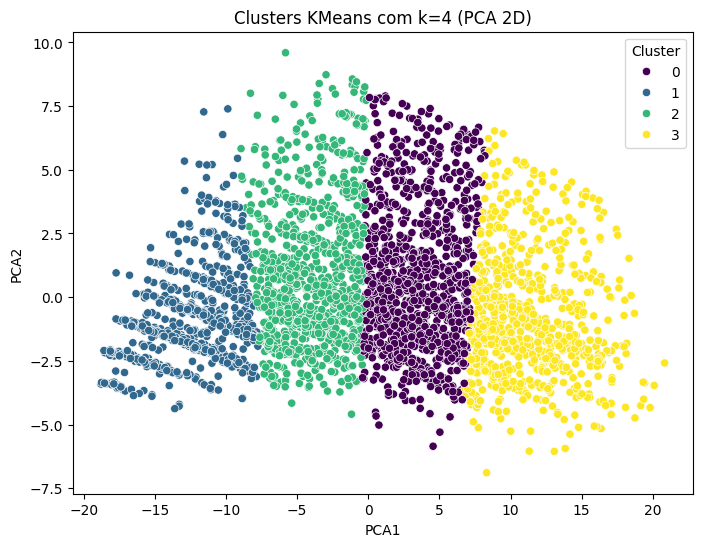

In [179]:
PlotKmeans(best_k=2)
PlotKmeans(best_k=4)

In [ ]:
# sil_score = silhouette_score(df_processed.drop('Cluster_KMeans', axis=1), labels)
# db_score = davies_bouldin_score(df_processed.drop('Cluster_KMeans', axis=1), labels)
# ch_score = calinski_harabasz_score(df_processed.drop('Cluster_KMeans', axis=1), labels)

# print(f"Silhouette Score: {sil_score:.3f}")
# print(f"Davies-Bouldin Score: {db_score:.3f}")
# print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# Interpretação:
# - Silhouette: quanto maior, melhor (idealmente > 0.5)
# - Davies-Bouldin: quanto menor, melhor
# - Calinski-Harabasz: quanto maior, melhor


Silhouette Score: 0.497
Davies-Bouldin Score: 0.710
Calinski-Harabasz Score: 6161.805


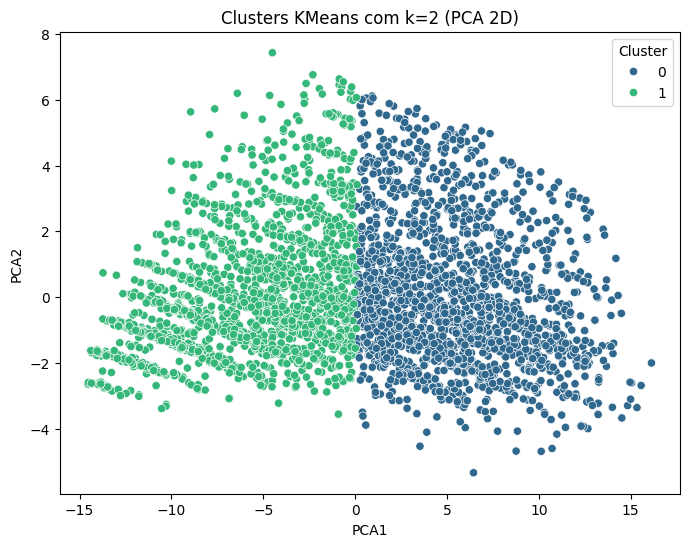

In [ ]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(df_processed.drop('Cluster_KMeans', axis=1))

# df_processed['PCA1'] = pca_result[:, 0]
# df_processed['PCA2'] = pca_result[:, 1]

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_KMeans', palette='viridis', data=df_processed)
# plt.title(f'Clusters KMeans com k={best_k} (PCA 2D)')
# plt.legend(title='Cluster')
# plt.show()

# Justificativa:
# PCA reduz a dimensionalidade preservando a variância, útil para visualizar dados em 2D


# Clusterização Espacial Baseada em Densidade (DBSCAN)

Vamos agrupar os dados com base na densidade, encontrando assim, clusters de formatos irregulares e identificando outliers.

Mas antes, vamos importar as bibliotecas necessárias e preparar os dados. Garantindo que vamos usar o conjunto de dados completo e aplicar o mesmo pré-processamento de escalonamento (StandardScaler) e codificação (OneHotEncoder) usado anteriormente.

In [180]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## Determinando os hiperparâmetros do DBSCAN

Valor de min_samples (2 * D): 15


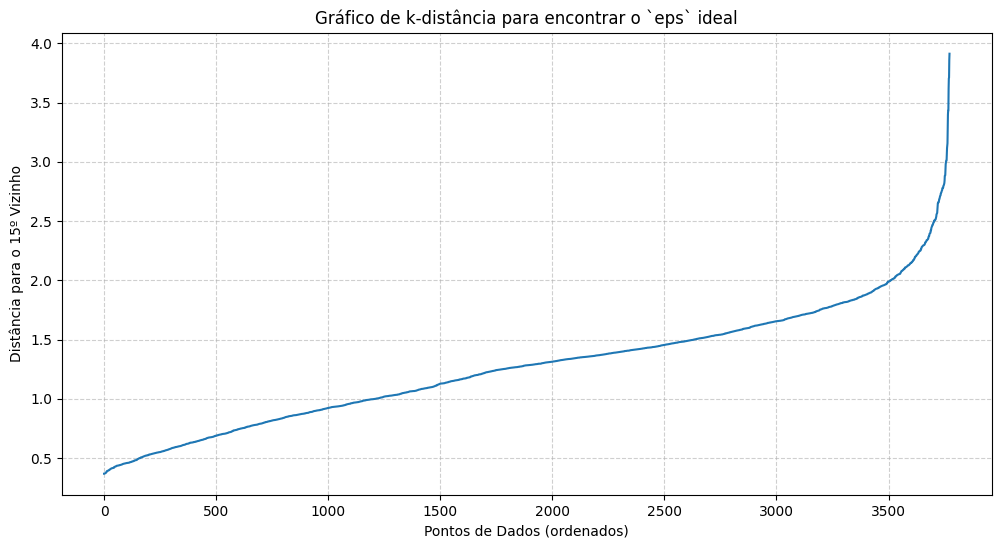

In [207]:
# 1. Definindo min_samples
D = df_processed.shape[1]
min_samples = 15
print(f"Valor de min_samples (2 * D): {min_samples}")

# 2. Encontrando o eps ideal com o gráfico de k-distância
k = min_samples
neighbors = NearestNeighbors(n_neighbors=k).fit(df_processed)
distances, indices = neighbors.kneighbors(df_processed)
k_distances = np.sort(distances[:, k-1], axis=0)

# Plotando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(k_distances)
plt.title('Gráfico de k-distância para encontrar o `eps` ideal')
plt.xlabel('Pontos de Dados (ordenados)')
plt.ylabel(f'Distância para o {k}º Vizinho')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [195]:
# Com base no gráfico, um valor em torno de 1.7 parece ser o ponto de cotovelo.
eps_escolhido = 2


## Treinamento e Análise do Modelo DBSCAN

In [208]:
# Instanciando e treinando o modelo DBSCAN
dbscan = DBSCAN(eps=eps_escolhido, min_samples=min_samples)
clusters_dbscan = dbscan.fit_predict(df_processed)

# Analisando os resultados
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"Número de clusters encontrados: {n_clusters}")
print(f"Número de pontos de ruído (outliers): {n_noise}")
print("\nContagem de pontos por cluster:")
print(pd.Series(clusters_dbscan).value_counts())

Número de clusters encontrados: 3
Número de pontos de ruído (outliers): 64

Contagem de pontos por cluster:
 0    1761
 1    1187
 2     761
-1      64
Name: count, dtype: int64


## Avaliação e Visualização dos Clusters

In [ ]:
# Instanciando e treinando o modelo DBSCAN
dbscan = DBSCAN(eps=eps_escolhido, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(df_processed)

X_for_metrics = df_processed.copy()

sil_score_dbscan = silhouette_score(X_for_metrics, dbscan_labels)

db_score_dbscan = davies_bouldin_score(X_for_metrics, dbscan_labels)

ch_score_dbscan = calinski_harabasz_score(X_for_metrics, dbscan_labels)

print("\n--- Métricas de Avaliação ---")
print(f"Silhouette Score: {sil_score_dbscan:.3f}")
print(f"Davies-Bouldin Score: {db_score_dbscan:.3f}")
print(f"Calinski-Harabasz Score: {ch_score_dbscan:.3f}")



--- Métricas de Avaliação ---
Silhouette Score: 0.393
Davies-Bouldin Score: 2.314
Calinski-Harabasz Score: 3192.604



Coeficiente de Silhueta para os pontos principais: 0.4110


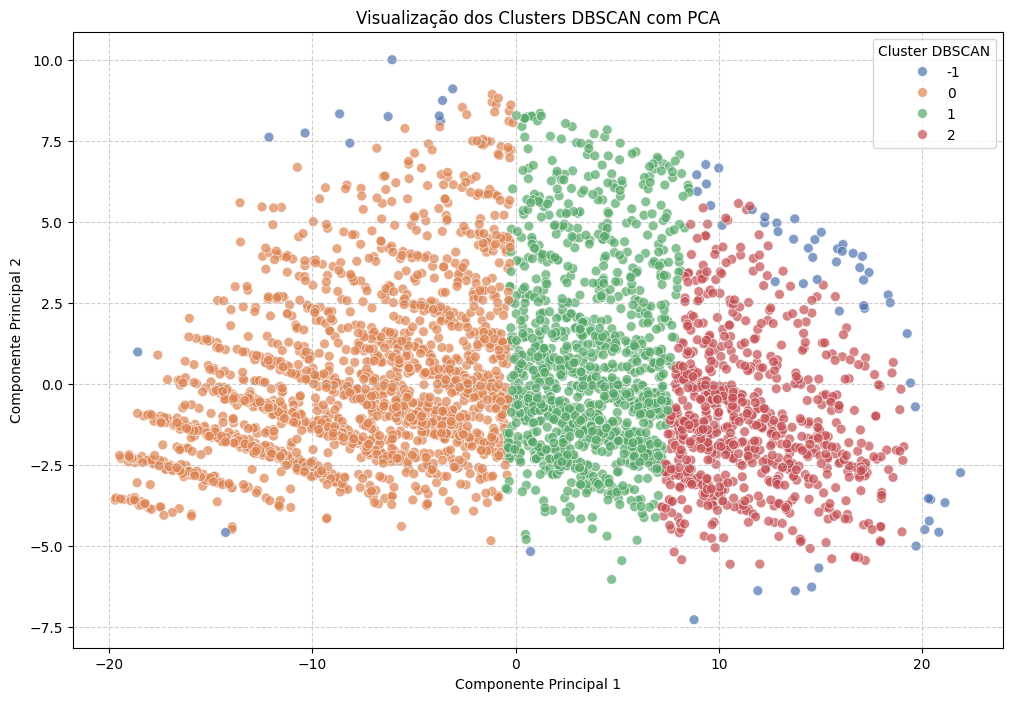

In [213]:
# Calculando o Coeficiente de Silhueta (apenas nos pontos principais)
mask_core_points = clusters_dbscan != -1
if np.sum(mask_core_points) > 0 and len(set(clusters_dbscan[mask_core_points])) > 1:
    silhouette_avg = silhouette_score(df_processed[mask_core_points], clusters_dbscan[mask_core_points])
    print(f"\nCoeficiente de Silhueta para os pontos principais: {silhouette_avg:.4f}")
else:
    print("\nNão foi possível calcular o Coeficiente de Silhueta.")

# Visualizando os clusters com PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_processed)

# Criando o gráfico de dispersão
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=clusters_dbscan,
    palette='deep',
    s=50,
    alpha=0.7
)
plt.title('Visualização dos Clusters DBSCAN com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster DBSCAN')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()